In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, AveragePooling2D, Conv2DTranspose, Flatten, Reshape, Layer
from tensorflow.keras.models import Model
import numpy as np
from netCDF4 import Dataset
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime as dt
from sklearn.model_selection import train_test_split

In [2]:
#set the paths
data_path = '/Users/justinhudson/Documents/HW/ATS_780/Homework_2/DATA/'
figure_path = '/Users/justinhudson/Documents/HW/ATS_780/Homework_2/FIGURES/'
root = '/Users/justinhudson/Documents/HW/ATS_780/Homework_2/CODE'

In [3]:
# set the seed
rand_seed = 144
np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)

### DATA PREPARATION

In [4]:
#bring in the data
os.chdir(data_path)
e5data = Dataset('ERA5_200hpa_U_V_relVort_Colorado_2021_2022.nc')
u = e5data.variables['u'][:]
v = e5data.variables['v'][:]
vort = e5data.variables['vo'][:]
lats = e5data.variables['latitude'][:]
lons = e5data.variables['longitude'][:]
time = e5data.variables['time'][:]
#convert times to usable dates
ref_date = dt.datetime(1900,1,1)
dates = np.array( [ ref_date + dt.timedelta(hours = int(t)) for t in time ] )

In [5]:
# normalize the data
def normalize_data(dataset:np.ndarray) -> np.ndarray:
    '''
        Normalizes data so that it is on the range 0-1 and then returns
        the normalized data.

        Inputs:
            dataset (np.ndarray): The dataset to be normalized
        
        Outputs:
            norm_data (np.ndarray): The normalized data
    '''

    data_min = np.nanmin(dataset)
    data_max = np.nanmax(dataset)

    norm_data = (dataset[:] - data_min) / (data_max - data_min)

    return norm_data, data_min, data_max

def denormalize_data(normed_data:np.ndarray,orig_min:float,orig_max:float) -> np.ndarray:
    '''
        De-normalizes a dataset using the min and max from the
        original dataset.

        Inputs:
            normed_data (np.ndarray): The dataset to be de-normalized, should
                have a range of [0-1]
            orig_min (float): The original minima of the dataset which was
                used to normalize it
            orig_max (float): The original maxima of the dataset which was
                used to normalize it
        
        Returns:
            denormed_data (np.ndarray): The denormalized dataset which should
                have a range of [orig_min,orig_max]
    '''

    denormed_data = (normed_data * (orig_max - orig_min)) + orig_min

    return denormed_data

u_norm,u_min,u_max = normalize_data(u)
v_norm,v_min,v_max = normalize_data(v)
vort_norm,vort_min,vort_max = normalize_data(vort)

In [6]:
# Combine u and v such that they are images with 2 "channels"
uv_data = np.empty((u.shape[0],u.shape[1],u.shape[2],2))
uv_data[:,:,:,0] = u_norm[:]
uv_data[:,:,:,1] = v_norm[:]
# uv_data is a 4D array of shape (time,lat,lon,channel)

In [7]:
# Split the data in testing/validation/training
# 10% will be testing
# 20% of the remainder will be validation
# the remainder of that will be training data


x_train,x_test,y_train,y_test = train_test_split(uv_data,vort_norm,test_size=0.1,
                                                 shuffle=True, random_state= rand_seed)
#now split off the validation from the training
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,
                                               shuffle = True,random_state= rand_seed)

# print the shapes to verify things look right
print("TRAINING, VALIDATION, AND TESTING SHAPES:")
print(f'XTRAIN: {x_train.shape}, XVAL: {x_val.shape}, XTEST: {x_test.shape}')
print(f'YTRAIN: {y_train.shape}, YVAL: {y_val.shape}, YTEST: {y_test.shape}')

TRAINING, VALIDATION, AND TESTING SHAPES:
XTRAIN: (12614, 25, 41, 2), XVAL: (3154, 25, 41, 2), XTEST: (1752, 25, 41, 2)
YTRAIN: (12614, 25, 41), YVAL: (3154, 25, 41), YTEST: (1752, 25, 41)


### Custom Loss Functions Are Defined Here

We want our loss function to be done pixel wise because the goal is to recreate the entire relative vorticity field.

In [8]:
def custom_mse(truth:np.ndarray,predictions:np.ndarray) -> float:
    '''
        Calculates the pixel wise Mean Squared Error (MSE) and returns it.

        Inputs:
            predictions (np.ndarray): The prediction made by the neural network
            truth (np.ndarray): The truth value corresponding to that sample
        
        Returns:
            loss (float): The mean-squared error (MSE) of the entire sample calculated
                at each pixel and then summed together
    '''
    loss = tf.add_n(tf.square(tf.subtract(truth,predictions)))

    return loss

def custom_mae_times_ten_to_the_Nth(truth:np.ndarray,prediction:np.ndarray) -> float:
    '''
        Calculates the pixel wise Mean Absolute Error (MAE) and then
        multiplies it by 10^N since relative vorticitity is a small
        number this ensures differences are exaggerated and blown up
        for my metric

        Inputs:
            truth (np.ndarray): The truth value corresponding to the
                sample ingested by the network
            prediction (np.ndarray): The prediction made by the network
                after ingesting a sample
        
        Returns:
            mae_10_N (float): The MAE multiplied by 10^N
    '''
    mae_10_N = tf.multiply(tf.add_n(tf.abs(tf.subtract(truth,prediction))),maeN)

    return mae_10_N




In [9]:
maeN = 1e8
custom_mae_times_ten_to_the_Nth(np.ones(100),np.ones(100)+1e-7)

2023-10-26 10:38:40.690264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(), dtype=float64, numpy=1000.0000005838672>

### Model is Defined Here

Want to use a CNN for this task since spatial information of nearby pixels
is part of how relative vorticity is calculated

In [10]:
def compile_model() -> None:
    '''
        Constructs the CNN Model
    '''
    global model

    # Input Layers
    input_layer = Input(shape=x_train.shape[1:]) # (lat,lon, channels)

    layers = Layer()(input_layer)

    # Convolutional Layers
    for ilay in range(N_CONV_LAYERS):
        layers = Conv2D(N_FILTERS,KERNEL_SIZE, strides = STRIDE,
                        activation = CONV_ACTIVATION, padding = 'same')(layers)
    layers = DOWNSAMPLING2D(POOL_SIZE, padding = 'same')(layers)

    conv_shape = layers.shape

    # Transpose Convolutional Layers
    for ilay in range(N_CONV_LAYERS):
        layers = Conv2DTranspose(N_FILTERS,KERNEL_SIZE,strides = STRIDE,
                                 activation=CONV_ACTIVATION, padding='same')(layers)
    layers = UpSampling2D(POOL_SIZE)(layers)
    output_layer = Conv2D(1, KERNEL_SIZE, activation='linear', padding='same')(layers)

    # Contruct the model
    model = Model(input_layer,output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,loss = LOSS, metrics=[METRIC])

    model.summary()

def fit_model():
    global history

    history = model.fit(x_train,y_train, epochs = NUM_EPOCHS, verbose=VERBOSITY,
                        batch_size = BATCH_SIZE, shuffle=True, validation_data=[x_val,y_val],
                        callbacks=[early_stopping_callback])

def train_model():
    compile_model()
    fit_model()

In [18]:
# DEFINE MODEL HYPERPARAMETERS HERE

SEED = rand_seed #keep my randomseed the same throughout the notebook

LOSS = 'mse'
METRIC = 'mae'

NUM_EPOCHS = 1000
BATCH_SIZE = 32
VERBOSITY = 2
LEARNING_RATE = 1e-4

# CONVOLUTIONAL LAYER CHOICES
N_CONV_LAYERS = 2
N_FILTERS = 10
KERNEL_SIZE = (3,3)
STRIDE = (1,1)
CONV_ACTIVATION = 'relu'

DOWNSAMPLING2D = MaxPooling2D
#DOWNSAMPLING2D = AveragePooling2D
POOL_SIZE = (1,1)

# DENSE LAYER CHOICES
N_DENSE_LAYERS = 0
DENSE_ACTIVATION = 'sigmoid'
N_NODES = 5
L1 = 0
L2 = 0

# DEFINE EARLY STOPPING
PATIENCE = 10
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience=PATIENCE,restore_best_weights=True,
    mode="auto",verbose=1
)

In [19]:
# COMPILE FIT AND THEN TRAIN THE MODEL HERE
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(rand_seed)
train_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 41, 2)]       0         
                                                                 
 layer (Layer)               (None, 25, 41, 2)         0         
                                                                 
 conv2d (Conv2D)             (None, 25, 41, 10)        190       
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 41, 10)        910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 41, 10)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 25, 41, 10)       910       
 nspose)                                                     

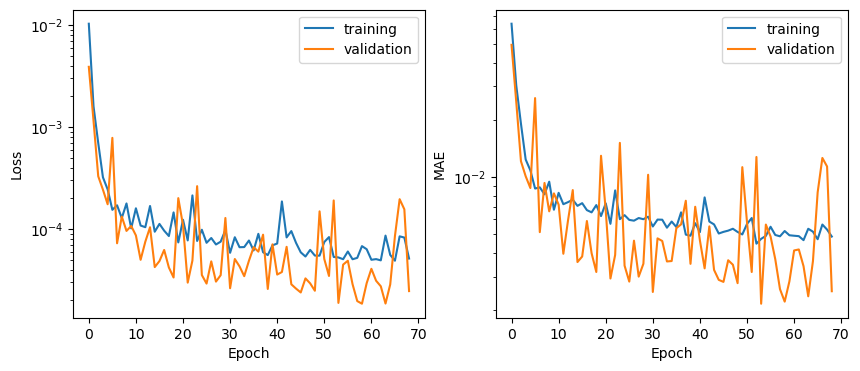

In [22]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

ax[0].plot(history.history["loss"],label = "training")
ax[0].plot(history.history["val_loss"],label = "validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend(loc = 'best')
ax[0].set_yscale('log')

ax[1].plot(history.history["mae"],label = "training")
ax[1].plot(history.history["val_mae"],label = "validation")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("MAE")
ax[1].legend(loc = 'best')
ax[1].set_yscale('log')

plt.show()